In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import matplotlib
matplotlib.rc('font', family = 'Malgun Gothic')
matplotlib.rc('axes', unicode_minus = False)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pmdarima import auto_arima

# 확인1

In [2]:
# CSV 파일을 데이터프레임으로 불러오기
sales_data = pd.read_csv('C:/Users/campus4D045/Desktop/data/sales_data.csv')
member_data = pd.read_csv('C:/Users/campus4D045/Desktop/data/member_data.csv')
product_data = pd.read_csv('C:/Users/campus4D045/Desktop/data/product_data.csv')

In [398]:
sales_data.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호,배송기간,오전오후
0,1032097472,정상회원,1.0,7083,2022-01-08,NaT,NaT,0,0,주문취소,13:00:00,100021783V2_1337,NaT,오후
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,13:00:00,100022137V2_1606,0 days,오후
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,13:00:00,100021452V2_1113,1 days,오후
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,13:00:00,10002931V2_708,1 days,오후
4,1032097472,정상회원,1.0,8423,2022-01-08,NaT,NaT,0,0,주문취소,13:00:00,100022085V2_1559,NaT,오후


In [397]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/data/sales_data1.csv'
sales_data.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/data/sales_data1.csv 경로에 저장되었습니다.


# sales_data 주문일시, 배송시작일, 배송완료일 datetime
# 주문시간 범주화
# 배송기간

In [301]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 668111 entries, 0 to 668110
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype          
---  ------      --------------   -----          
 0   회원번호        668111 non-null  int64          
 1   회원상태        668109 non-null  object         
 2   구매수량        668111 non-null  float64        
 3   구매금액        668111 non-null  int64          
 4   주문일시        668111 non-null  datetime64[ns] 
 5   배송시작일       637476 non-null  datetime64[ns] 
 6   배송완료일       637476 non-null  datetime64[ns] 
 7   사용 적립금      668111 non-null  int64          
 8   사용 포인트 네이버  668111 non-null  int64          
 9   주문취소여부      30635 non-null   object         
 10  주문시간        668111 non-null  object         
 11  제품번호        668111 non-null  object         
 12  배송기간        637476 non-null  timedelta64[ns]
 13  오전오후        668111 non-null  object         
dtypes: datetime64[ns](3), float64(1), int64(4), object(5), timedelta64[ns](1)
memory usa

In [367]:
# '주문일시' 열을 datetime 형식으로 변환
sales_data['주문일시'] = pd.to_datetime(sales_data['주문일시'])

# '배송시작일' 열을 datetime 형식으로 변환
sales_data['배송시작일'] = pd.to_datetime(sales_data['배송시작일'])

# '배송완료일' 열을 datetime 형식으로 변환
sales_data['배송완료일'] = pd.to_datetime(sales_data['배송완료일'])

In [368]:
sales_data['배송기간'] = sales_data['배송완료일'] - sales_data['배송시작일']

In [369]:
# '오전'/'오후' 부분 추출하여 '오전오후' 열 생성
sales_data['오전오후'] = sales_data['주문시간'].str.split(' ').str[0]

# 시간 부분 추출하여 '주문시간' 열 갱신
sales_data['주문시간'] = sales_data['주문시간'].str.split(' ').str[1]

In [370]:
# 유효한 시간 형식으로 변환하는 함수 정의
def correct_time_format(time_str):
    hours, minutes = map(int, time_str.split(':'))
    if minutes >= 60:
        hours += minutes // 60
        minutes = minutes % 60
    return f'{hours:02}:{minutes:02}'

# '주문시간' 열을 유효한 시간 형식으로 변환
sales_data['주문시간'] = sales_data['주문시간'].apply(correct_time_format)

# '주문시간'을 datetime 형식으로 변환 후 시간 부분만 추출
sales_data['주문시간'] = pd.to_datetime(sales_data['주문시간'], format='%H:%M').dt.time

In [371]:
# '배송완료일'이 NaN 값인 행만 선택
df_nan_배송완료일 = sales_data[sales_data['배송완료일'].isna()]

# 그 중에서 '주문취소여부'가 NaN인 행 선택
result = df_nan_배송완료일[df_nan_배송완료일['주문취소여부'].isna()]

# 결과 출력
print(result)

Empty DataFrame
Columns: [회원번호, 회원상태, 구매수량, 구매금액, 주문일시, 배송시작일, 배송완료일, 사용 적립금, 사용 포인트 네이버, 주문취소여부, 주문시간, 제품번호, 배송기간, 오전오후]
Index: []


In [372]:
sales_data['배송기간'].unique()

<TimedeltaArray>
[NaT, '0 days', '1 days', '2 days', '4 days', '3 days', '5 days']
Length: 7, dtype: timedelta64[ns]

# sales_data 이상치 확인

<Axes: >

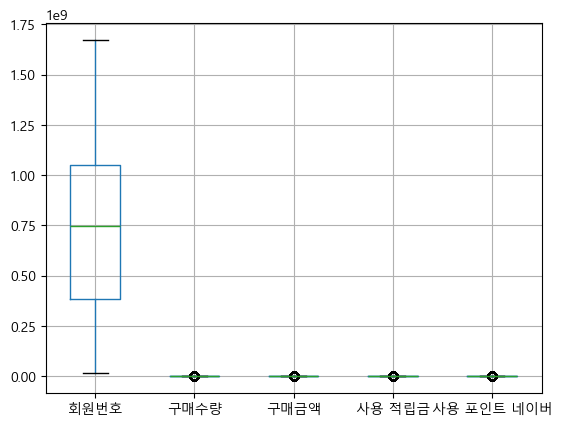

In [7]:
sales_data.boxplot()

<Axes: >

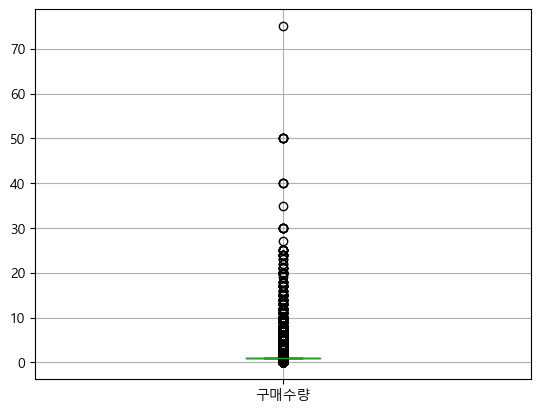

In [8]:
sales_data.boxplot(['구매수량'])

In [375]:
sales_data[sales_data['구매수량'].apply(lambda x: isinstance(x, float) and not x.is_integer())]

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호,배송기간,오전오후


In [374]:
# 소수인 구매수량 행 필터링
mask = sales_data['구매수량'].apply(lambda x: isinstance(x, float) and not x.is_integer())

# 소수인 구매수량 행 삭제
sales_data = sales_data[~mask]

<Axes: >

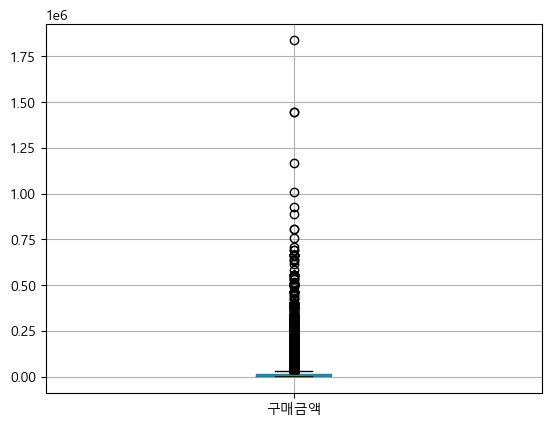

In [378]:
sales_data.boxplot(['구매금액'])

In [377]:
max_value = sales_data['구매금액'].max()
max_value2 = sales_data[sales_data['구매금액'] < max_value]['구매금액'].max()
sales_data = sales_data[~sales_data['구매금액'].isin([max_value, max_value2])]

In [379]:
sales_data['구매금액'].max()

1837838

<Axes: >

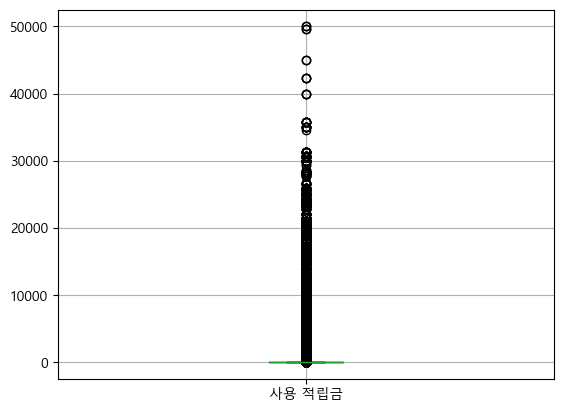

In [382]:
sales_data.boxplot(['사용 적립금'])

In [235]:
sales_data['사용 적립금'].isnull().sum()

0

In [381]:
max_value = sales_data['사용 적립금'].max()
sales_data = sales_data[~sales_data['사용 적립금'].isin([max_value])]

<Axes: >

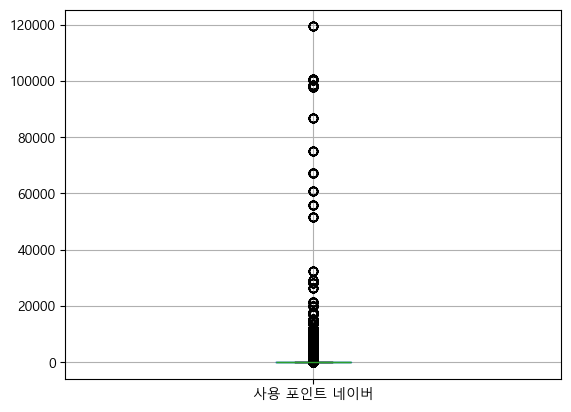

In [384]:
sales_data.boxplot(['사용 포인트 네이버'])

In [204]:
sales_data['사용 포인트 네이버'].max()

251600

In [383]:
max_value = sales_data['사용 포인트 네이버'].max()
sales_data = sales_data[~sales_data['사용 포인트 네이버'].isin([max_value])]

In [385]:
# '회원상태' 열에 NaN이 포함된 행 제거
sales_data.dropna(subset=['회원상태'], inplace=True)

# Sales_data 결측치 확인

In [386]:
sales_data['회원상태'].isnull().sum()
# 비회원 처리

0

In [387]:
sales_data['구매수량'].isnull().sum()

0

In [388]:
sales_data['구매금액'].isnull().sum()

0

In [389]:
sales_data['구매금액'].isnull().sum()

0

In [390]:
sales_data['주문일시'].isnull().sum()

0

In [391]:
sales_data['배송시작일'].isnull().sum()

30458

In [392]:
sales_data['배송완료일'].isnull().sum()

30458

In [393]:
sales_data['사용 적립금'].isnull().sum()

0

In [394]:
sales_data['사용 포인트 네이버'].isnull().sum()

0

In [395]:
sales_data['주문취소여부'].isnull().sum()

633336

In [396]:
sales_data['주문시간'].isnull().sum()

0

In [216]:
# # '회원상태' 열의 NaN, None, 'nan' 값을 '비회원'으로 대치
# sales_data['회원상태'] = sales_data['회원상태'].replace(['nan', None, np.nan], '비회원')

In [222]:
sales_data[sales_data['회원상태'] == '비회원'].dropna(inplace = True)

In [223]:
print(sales_data[sales_data['회원상태'] == '비회원'])

             회원번호 회원상태  구매수량   구매금액       주문일시      배송시작일      배송완료일  사용 적립금  \
224551  409140352  비회원   2.0  26036 2022-04-02 2022-04-02 2022-04-03       0   
224554  409140352  비회원   1.0   1149 2022-04-02 2022-04-03 2022-04-03       0   

        사용 포인트 네이버 주문취소여부      주문시간              제품번호   배송기간 오전오후  
224551           0    nan  07:21:00  100021448V2_1109 1 days   오후  
224554           0    nan  07:21:00  100022238V2_1687 0 days   오후  


# member_data 이상치 확인

In [16]:
member_data.head()

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구
1,18792000,정상회원,남,83,연결앱결제,NaN,False,강원도,강릉시
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구
3,18949760,정상회원,여,73,기업은행,NaN,NaN,강원도,홍천군
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구


In [5]:
# '구독여부'가 True인 경우의 수
true_count = member_data[member_data['구독여부'] == True]['회원번호'].nunique()

# '구독여부'가 False인 경우의 수
false_count = member_data[member_data['구독여부'] == False]['회원번호'].nunique()

print("구독여부가 True인 경우의 수:", true_count)
print("구독여부가 False인 경우의 수:", false_count)

구독여부가 True인 경우의 수: 1753
구독여부가 False인 경우의 수: 8441


In [4]:
member_data['회원번호'].nunique()

12540

In [271]:
member_data['결혼'].isnull().sum()

2717

In [291]:
member_data['결혼'].unique()

array(['기혼', '미확인', '미혼'], dtype=object)

In [62]:
# member_data['결혼'] == 'NaN'에 해당하는 사람들 연령 및 처리
# 미확인으로 대치

0        False
1         True
2        False
3         True
4        False
         ...  
12535    False
12536    False
12537     True
12538    False
12539    False
Name: 결혼, Length: 12540, dtype: bool

In [337]:
# '등록카드' 열의 NaN, None, 'nan' 값을 '무통장계좌이체'으로 대치
member_data['결혼'] = member_data['결혼'].replace(['nan', None, np.nan], '미확인')

In [274]:
member_data['회원번호'].isnull().sum()

0

In [275]:
member_data['회원상태'].isnull().sum()

1

In [276]:
member_data['성별'].isnull().sum()

1

In [277]:
member_data['나이'].isnull().sum()

0

In [339]:
member_data['결혼'].isnull().sum()

0

In [280]:
member_data['구독여부'].isnull().sum()

2346

In [283]:
member_data['세부주소지'].isnull().sum()

9

In [341]:
member_data['등록카드'].unique()
# nan > 무통장계좌이체

array(['농협중앙회', '연결앱결제', '신한은행', '기업은행', '롯데카드', '삼성카드', '우체국', '우리은행',
       '하나은행', '현대카드', '신한카드', '국민은행', '부산은행', 'BC카드', '씨티은행', '국민카드',
       '광주은행', '새마을금고', '신협중앙회', '대구은행', 'SC제일은행', '외환은행', '미래에셋증권',
       '경남은행', '무통장계좌이체'], dtype=object)

In [340]:
# '등록카드' 열의 NaN, None, 'nan' 값을 '무통장계좌이체'으로 대치
member_data['등록카드'] = member_data['등록카드'].replace(['nan', None, np.nan], '무통장계좌이체')

In [172]:
member_data['성별'].isnull().sum()
# 제거

1

<Axes: >

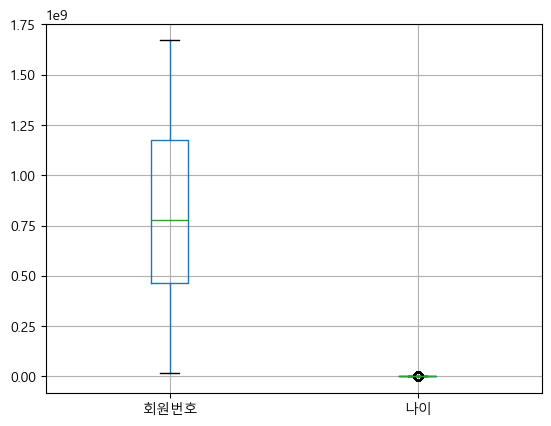

In [17]:
member_data.boxplot()

<Axes: >

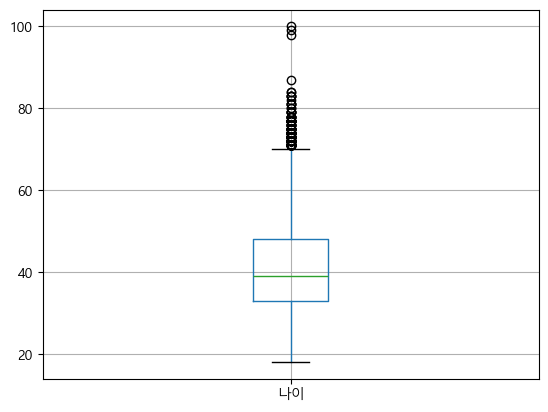

In [18]:
member_data.boxplot(['나이'])

In [19]:
sorted(member_data['나이'].unique(), reverse=True)
# IQR 이상치 처리

[100,
 99,
 98,
 87,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 19,
 18]

In [285]:
# pandas Series로 변환
data_series = pd.Series(member_data['나이'])

# 1사분위수(Q1)와 3사분위수(Q3) 계산
Q1 = data_series.quantile(0.25)
Q3 = data_series.quantile(0.75)

# IQR 계산
IQR = Q3 - Q1

# 하한과 상한 계산
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 식별
outliers = data_series[(data_series < lower_bound) | (data_series > upper_bound)]

# 결과 출력
print(f"1사분위수(Q1): {Q1}")
print(f"3사분위수(Q3): {Q3}")
print(f"IQR: {IQR}")
print(f"하한: {lower_bound}")
print(f"상한: {upper_bound}")
print(f"이상치: {outliers.tolist()}")

# 이상치의 개수 조회 및 출력
outliers_count = outliers.count()
print(f"이상치의 개수: {outliers_count}")

1사분위수(Q1): 33.0
3사분위수(Q3): 48.0
IQR: 15.0
하한: 10.5
상한: 70.5
이상치: [83, 73, 72, 77, 72, 81, 73, 71, 72, 71, 72, 72, 73, 76, 76, 83, 71, 79, 81, 81, 71, 74, 74, 77, 71, 77, 73, 74, 79, 71, 74, 73, 84, 72, 71, 71, 71, 72, 73, 72, 72, 74, 77, 71, 72, 71, 75, 80, 74, 73, 72, 79, 77, 78, 71, 74, 71, 72, 72, 74, 74, 71, 72, 72, 71, 72, 72, 75, 77, 71, 77, 72, 74, 72, 73, 72, 77, 71, 74, 78, 75, 71, 71, 71, 72, 75, 77, 72, 72, 72, 72, 75, 71, 78, 71, 71, 72, 72, 71, 71, 74, 72, 76, 73, 77, 75, 71, 77, 78, 77, 74, 72, 71, 73, 73, 71, 76, 71, 99, 71, 72, 76, 72, 71, 74, 77, 87, 74, 73, 76, 83, 71, 72, 75, 74, 75, 81, 80, 71, 71, 77, 98, 71, 73, 71, 74, 73, 72, 75, 71, 73, 71, 72, 82, 78, 74, 72, 77, 74, 73, 74, 74, 72, 73, 73, 71, 71, 71, 78, 73, 75, 73, 71, 71, 79, 72, 83, 71, 71, 74, 71, 79, 74, 73, 74, 71, 84, 75, 71, 72, 72, 71, 73, 73, 71, 74, 77, 74, 74, 73, 71, 74, 100]
이상치의 개수: 203


In [174]:
member_data['회원번호'].isnull().sum()

0

In [175]:
member_data['주소지'].isnull().sum()

3

In [176]:
member_data['주소지'].dropna(inplace = True)

# member_data 구독여부 비율 확인

In [177]:
member_data['구독여부'].unique()

array([False, nan, True], dtype=object)

In [178]:
# 구독여부의 비율 계산
subscription_counts = member_data['구독여부'].value_counts(dropna=False)
total_count = len(member_data['구독여부'])

# 비율 계산
subscription_ratios = subscription_counts / total_count * 100

# 비율 출력
print(subscription_ratios)

구독여부
False    67.312600
NaN      18.708134
True     13.979266
Name: count, dtype: float64


In [352]:
member_data['회원상태'].unique()

array(['정상회원', '탈퇴', '탈퇴처리중', '탈퇴신청'], dtype=object)

In [344]:
# '회원상태' 열에 NaN이 포함된 행 제거
member_data.dropna(subset=['회원상태'], inplace=True)

In [353]:
member_data['성별'].unique()

array(['여', '남'], dtype=object)

In [343]:
# '성별' 열에 NaN이 포함된 행 제거
member_data.dropna(subset=['성별'], inplace=True)

In [347]:
member_data['주소지'].isnull().sum()

0

In [342]:
# '세부주소지' 열에 NaN이 포함된 행 제거
member_data.dropna(subset=['세부주소지'], inplace=True)

In [351]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/data/member_data1.csv'
member_data.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/data/member_data1.csv 경로에 저장되었습니다.


In [350]:
member_data['나이'].unique()

array([68, 83, 39, 73, 52, 45, 50, 53, 43, 58, 41, 48, 42, 46, 44, 62, 65,
       47, 38, 64, 49, 40, 66, 57, 54, 67, 63, 51, 55, 56, 70, 61, 59, 33,
       69, 72, 36, 77, 60, 81, 71, 37, 76, 79, 31, 34, 74, 35, 30, 32, 84,
       29, 28, 75, 80, 78, 23, 25, 26, 24, 27, 21, 87, 22, 19, 82, 20, 18],
      dtype=int64)

In [349]:
# 1. NaN 값을 포함한 행을 먼저 제거합니다 (선택 사항)
member_data.dropna(subset=['나이'], inplace=True)

# 2. '나이'가 71 이상인 행을 제거합니다
member_data = member_data[member_data['나이'] < 90]

In [180]:
# 회원상태의 비율 계산
status_counts = member_data['회원상태'].value_counts(dropna=False)
total1_count = len(member_data['회원상태'])

# 비율 계산
status_ratios = status_counts / total1_count * 100

# 비율 출력
print(status_ratios)

회원상태
정상회원     98.724083
탈퇴        1.244019
탈퇴처리중     0.015949
NaN       0.007974
탈퇴신청      0.007974
Name: count, dtype: float64


# Product_data 이상치 확인

In [305]:
product_data.head()

,제품번호,물품명,물품대분류,물품중분류,상품중량
0,100021V2_0,2단무늬컵,식기/편백,자기,1p
1,100022V2_1,7곡딸기롤과자,과자,스낵,100g/10개입
2,100023V2_2,7곡참식,식사대용,선식/생식,700g
3,100024V2_3,가리비,생물수산,패류/갑각류,1.5kg
4,100025V2_3,가리비,생물수산,패류/갑각류,1kg


In [292]:
product_data['제품번호'].isnull().sum()

0

In [183]:
product_data['물품명'].isnull().any()

False

In [184]:
product_data['물품대분류'].isnull().any()

False

In [185]:
product_data['물품중분류'].isnull().any()

False

In [293]:
product_data['상품중량'].isnull().sum()

219

In [187]:
# '상품중량'이 null인 행 필터링
null_weight_products = product_data[product_data['상품중량'].isnull()]

# 고유한 값 찾기
unique_null_weight_products = null_weight_products.drop_duplicates()

print(unique_null_weight_products)

                  제품번호           물품명   물품대분류   물품중분류 상품중량
5           100026V2_4        가마솥3인용   식기/편백      옹기  NaN
6           100027V2_5        가마솥5인용   식기/편백      옹기  NaN
8           100029V2_7     가브리살-성남용인  중량(정육)  돼지(중량)  NaN
31        1000232V2_23     갈매기살-성남용인  중량(정육)  돼지(중량)  NaN
55        1000256V2_39  감식초&개복숭아원액모음      음료    음료기타  NaN
...                ...           ...     ...     ...  ...
2477  100022478V2_1861    혼합표고선물모음1호      버섯    표고버섯  NaN
2478  100022479V2_1862    혼합표고선물모음3호      버섯    표고버섯  NaN
2482  100022483V2_1866      홍두깨-성남용인  중량(정육)  한우(중량)  NaN
2513  100022514V2_1892        황태선물모음     건어물     황태류  NaN
2536  100022537V2_1910   흑방울토마토_500g    과일채소   방울토마토  NaN

[219 rows x 5 columns]


# product_data 범주

In [306]:
product_data['물품대분류'].unique()

array(['식기/편백', '과자', '식사대용', '생물수산', '중량(정육)', '음료', '열매채소', '냉동수산',
       '말린나물/건재', '수산가공', '소스/기타양념', '육가공', '버섯', '과일', '기름/식초', '차',
       '밀가공', '빵', '가루', '해조', '잎/줄기채소', '김치', '생활용품', '세제/세안', '건강일반',
       '양념채소', '건어물', '즉석조리', '장', '콩/화본/깨', '견과', '어묵/묵', '밑반찬', '닭/오리',
       '소', '잼/병조림/기타', '알', '돼지', '소금', '뿌리채소', '떡', '홍삼/녹용', '쌈채소류',
       '꿀', '과실주', '과일채소', '유색미/발아미', '두부/유부', '절임/장아찌', '유제품', '전통주',
       '멥쌀', '보리/혼합곡', '화장품', '콩나물', '손질한채소', '섬유', '찹쌀', '김장채소'],
      dtype=object)

In [307]:
product_data['물품중분류'].unique()

array(['자기', '스낵', '선식/생식', '패류/갑각류', '옹기', '돼지(중량)', '발효음료', '과즙',
       '가시오이', '냉동생선', '가지', '가지말림', '게장/게살', '소스', '돈가스/분쇄가공', '수산가공반찬',
       '만가닥버섯', '양송이버섯', '귤(비가림)', '귤만감', '빙과', '곶감', '식초', '음료기타', '잎꽃차',
       '라면', '건강곡물빵', '과채가루', '생숙면', '기타해조류', '갓', '기타채소', '갓끈동부', '풋콩',
       '환경용품', '개복숭아', '살균/세정/탈취', '분말/환', '건고추', '곡류차', '건대추', '말린도라지',
       '목이버섯', '기타건어류', '국.찌개', '건강차', '장류/기타', '두유', '깨', '콩', '밤',
       '엿/양갱/기타', '묵', '피자/핫도그', '고구마순', '고구마순말림(70g)', '찐빵,호떡,전통',
       '케이크,롤,선물', '만두', '기타', '부각/튀각', '햄/소시지/훈제', '볶음', '기타양념', '고춧가루',
       '고춧잎', '프리믹스', '씨리얼', '곤드레나물/손질', '식사대용/기타', '곤드레잎', '기타생활용품',
       '곰취', '무항생제닭', '기타냉동수산', '유기한우', '공심채', '잼', '푸딩', '김', '김가공',
       '유정란', '보리살림돼지', '대용량물품(냉동수산)', '가공소금', '멸치류', '황태류', '천일염',
       '스테인리스', '화본', '귤(조생)', '숯/원예', '근대', '금이버섯', '한과/유과', '간편요리',
       '배추', '젓갈/액젓', '무', '더덕/손질', '도라지/손질', '깐마늘', '은행', '쪽파', '호두',
       '깻단', '깻잎', '새송이버섯', '즉석떡', '쿠키', '한우(중량)', '녹용', '상추', '기타(냉동 등)',
  

In [308]:
# 식품 목록
food_categories = [
    '과자', '음료', '빵', '밀가공', '건강일반', '콩/화본/깨', '가루', '식사대용', '차', '잼/병조림/기타', 
    '유색미/발아미', '보리/혼합곡', '꿀', '전통주', '과실주', '찹쌀', '소스/기타양념', '말린나물/건재', '장', 
    '견과', '즉석조리', '기름/식초', '홍삼/녹용', '맵쌀', '냉동수산', '소', '생물수산', '돼지', '중량(정육)', 
    '유제품', '닭/오리', '해조', '알', '두부/유부', '밑반찬', '김치', '콩나물', '손질한채소', '김장채소', 
    '과일', '잎/줄기채소', '열매채소', '뿌리채소', '과일채소', '양념채소', '절임/장아찌', '떡', '버섯', 
    '쌈채소류', '육가공', '수산가공', '건어물', '어묵/묵', '소금'
]

# 비식품 목록
non_food_categories = [
    '식기/편백', '생활용품', '화장품', '섬유', '세제/세안'
]
# 식품/비식품 구분 함수 정의
def classify_category(category):
    if category in food_categories:
        return '식품'
    elif category in non_food_categories:
        return '비식품'
    else:
        return '기타'

# 식품/비식품 컬럼 추가
product_data['식품/비식품'] = product_data['물품대분류'].apply(classify_category)

In [309]:
# 유기농 목록
organic_categories = [
    '과자', '음료', '빵', '밀가공', '건강일반', '콩/화본/깨', '가루', '식사대용', '차', '잼/병조림/기타', 
    '유색미/발아미', '보리/혼합곡', '꿀', '전통주', '과실주', '찹쌀', '소스/기타양념', '말린나물/건재', '장', 
    '견과', '즉석조리', '기름/식초', '홍삼/녹용', '맵쌀'
]

# 신선 목록
fresh_categories = [
    '냉동수산', '소', '생물수산', '돼지', '중량(정육)', 
    '유제품', '닭/오리', '해조', '알', '두부/유부'
]

# 신선/유기농 목록
orgfresh_categories = [
    '밑반찬', '김치', '콩나물', '손질한채소', '김장채소', 
    '과일', '잎/줄기채소', '열매채소', '뿌리채소', '과일채소', '양념채소', '절임/장아찌', '떡', '버섯', 
    '쌈채소류'
]

# 기타 목록
etc_categories = [
    '육가공', '수산가공', '건어물', '어묵/묵', '소금'
]

# 비식품 목록
non_food_categories = [
    '식기/편백', '생활용품', '화장품', '섬유', '세제/세안'
]

# 식품/비식품 구분 함수 정의
def classify_category(category):
    if category in organic_categories:
        return '유기농'
    elif category in fresh_categories:
        return '신선'
    elif category in orgfresh_categories:
        return '신선/유기농'
    elif category in etc_categories:
        return '기타'
    else:
        return '비식품'

# 식품/비식품 컬럼 추가
product_data['유기신선'] = product_data['물품대분류'].apply(classify_category)

In [310]:
product_data.head()

,제품번호,물품명,물품대분류,물품중분류,상품중량,식품/비식품,유기신선
0,100021V2_0,2단무늬컵,식기/편백,자기,1p,비식품,비식품
1,100022V2_1,7곡딸기롤과자,과자,스낵,100g/10개입,식품,유기농
2,100023V2_2,7곡참식,식사대용,선식/생식,700g,식품,유기농
3,100024V2_3,가리비,생물수산,패류/갑각류,1.5kg,식품,신선
4,100025V2_3,가리비,생물수산,패류/갑각류,1kg,식품,신선


In [311]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/data/product_data1.csv'
product_data.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/data/product_data1.csv 경로에 저장되었습니다.


# product_data 대분류 범주화

In [23]:
product_data['물품대분류'].unique()

array(['식기/편백', '과자', '식사대용', '생물수산', '중량(정육)', '음료', '열매채소', '냉동수산',
       '말린나물/건재', '수산가공', '소스/기타양념', '육가공', '버섯', '과일', '기름/식초', '차',
       '밀가공', '빵', '가루', '해조', '잎/줄기채소', '김치', '생활용품', '세제/세안', '건강일반',
       '양념채소', '건어물', '즉석조리', '장', '콩/화본/깨', '견과', '어묵/묵', '밑반찬', '닭/오리',
       '소', '잼/병조림/기타', '알', '돼지', '소금', '뿌리채소', '떡', '홍삼/녹용', '쌈채소류',
       '꿀', '과실주', '과일채소', '유색미/발아미', '두부/유부', '절임/장아찌', '유제품', '전통주',
       '멥쌀', '보리/혼합곡', '화장품', '콩나물', '손질한채소', '섬유', '찹쌀', '김장채소'],
      dtype=object)

In [54]:
product_data['물품대분류'].value_counts()
# 5개 품목 식품 아님(식기/편백, 생활용품, 화장품, 섬유, 세제/세안)

물품대분류
식기/편백       203
과일          139
냉동수산        108
음료          106
생활용품        101
잎/줄기채소       98
화장품          89
과자           83
소            74
섬유           73
빵            69
세제/세안        69
밀가공          64
생물수산         62
열매채소         59
육가공          58
건강일반         55
콩/화본/깨       55
가루           49
돼지           48
뿌리채소         47
과일채소         46
수산가공         43
중량(정육)       42
식사대용         40
차            39
양념채소         39
유제품          37
떡            37
건어물          36
버섯           34
소스/기타양념      32
말린나물/건재      32
닭/오리         31
장            30
해조           28
밑반찬          27
견과           25
즉석조리         21
김치           20
알            18
기름/식초        18
홍삼/녹용        16
쌈채소류         15
멥쌀           15
절임/장아찌       14
잼/병조림/기타     13
어묵/묵         13
두부/유부        13
소금           11
유색미/발아미      10
보리/혼합곡       10
꿀            10
전통주           8
과실주           6
찹쌀            5
콩나물           4
손질한채소         1
김장채소          1
Name: count, dtype: int64

In [36]:
categories = ['식기/편백', '생활용품', '화장품', '섬유', '세제/세안']

# 선택된 행 필터링
selected_rows = product_data['물품대분류'].isin(categories)

# 선택된 행의 개수
selected_count = selected_rows.sum()

# 전체 행의 개수
total_count = len(product_data)

# 퍼센트 계산
percentage = (selected_count / total_count) * 100

# 결과 출력
print(f"주어진 카테고리에 속하는 물품대분류의 퍼센트: {percentage:.2f}%")

주어진 카테고리에 속하는 물품대분류의 퍼센트: 20.99%


# 상품중량이 Null 인 값들 csv/xlsx 로 추출

In [57]:
# # '상품중량'이 null인 행 필터링
# null_weight_products = product_data[product_data['상품중량'].isnull()]

# # 고유한 값 찾기
# unique_null_weight_products = null_weight_products.drop_duplicates()

# # CSV로 추출
# output_path = "unique_null_weight_products.csv"
# unique_null_weight_products.to_csv(output_path, index=False)

# print(f"CSV file saved to {output_path}")

AttributeError: 'DataFrame' object has no attribute 'to_xlsx'

In [58]:
# # '상품중량'이 null인 행 필터링
# null_weight_products = product_data[product_data['상품중량'].isnull()]

# # 고유한 값 찾기
# unique_null_weight_products = null_weight_products.drop_duplicates()

# # Excel로 추출
# output_path = "unique_null_weight_products.xlsx"
# unique_null_weight_products.to_excel(output_path, index=False)

# print(f"Excel file saved to {output_path}")

Excel file saved to unique_null_weight_products.xlsx


In [ ]:
# 상품중량이 Null인 값 제거
# product_data.dropna(subset=['상품중량'])
# 상품중량이 Null인 값 제거 후 조회
# product_data[product_data['상품중량'].isnull()]

# Merge

In [399]:
sales_data1 = pd.read_csv('C:/Users/campus4D045/Desktop/data/sales_data1.csv')
member_data1 = pd.read_csv('C:/Users/campus4D045/Desktop/data/member_data1.csv')
product_data1 = pd.read_csv('C:/Users/campus4D045/Desktop/data/product_data1.csv')

In [400]:
sales_data1.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,주문시간,제품번호,배송기간,오전오후
0,1032097472,정상회원,1.0,7083,2022-01-08,NaN,NaN,0,0,주문취소,13:00:00,100021783V2_1337,NaN,오후
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,13:00:00,100022137V2_1606,0 days,오후
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,13:00:00,100021452V2_1113,1 days,오후
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,13:00:00,10002931V2_708,1 days,오후
4,1032097472,정상회원,1.0,8423,2022-01-08,NaN,NaN,0,0,주문취소,13:00:00,100022085V2_1559,NaN,오후


In [401]:
member_data1.head()

,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지
0,18764160,정상회원,여,68,농협중앙회,기혼,False,서울특별시,성동구
1,18792000,정상회원,남,83,연결앱결제,미확인,False,강원도,강릉시
2,18942336,정상회원,여,39,신한은행,기혼,False,인천광역시,중구
3,18949760,정상회원,여,73,기업은행,미확인,NaN,강원도,홍천군
4,19391488,정상회원,여,52,연결앱결제,기혼,False,대전광역시,중구


In [402]:
product_data1.head()

,제품번호,물품명,물품대분류,물품중분류,상품중량,식품/비식품,유기신선
0,100021V2_0,2단무늬컵,식기/편백,자기,1p,비식품,비식품
1,100022V2_1,7곡딸기롤과자,과자,스낵,100g/10개입,식품,유기농
2,100023V2_2,7곡참식,식사대용,선식/생식,700g,식품,유기농
3,100024V2_3,가리비,생물수산,패류/갑각류,1.5kg,식품,신선
4,100025V2_3,가리비,생물수산,패류/갑각류,1kg,식품,신선


In [406]:
# sales_data1와 member_data1를 member_id를 기준으로 병합
merged_data = pd.merge(sales_data1, member_data1, on='회원번호', how='left')

# merged_data1와 product_data1를 product_id를 기준으로 병합
final_data = pd.merge(merged_data, product_data1, on='제품번호', how='left')

# 결과 출력
final_data.head()

,회원번호,회원상태_x,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,...,결혼,구독여부,주소지,세부주소지,물품명,물품대분류,물품중분류,상품중량,식품/비식품,유기신선
0,1032097472,정상회원,1.0,7083,2022-01-08,NaN,NaN,0,0,주문취소,...,기혼,NaN,경기도,화성시,유정란/친환경,알,논지엠오유정란,10알,식품,신선
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,...,기혼,NaN,경기도,화성시,칠분도미/유,멥쌀,멥쌀,2kg,기타,비식품
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,기혼,NaN,경기도,화성시,양념닭갈비,육가공,양념육,500g,식품,기타
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,기혼,False,울산광역시,남구,볶음멸치/상,건어물,멸치류,300g,식품,기타
4,1032097472,정상회원,1.0,8423,2022-01-08,NaN,NaN,0,0,주문취소,...,기혼,NaN,경기도,화성시,채도라지,뿌리채소,도라지/손질,150g,식품,신선/유기농


In [407]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/data/final_data.csv'
final_data.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/data/final_data.csv 경로에 저장되었습니다.


In [408]:
final_data.columns

Index(['회원번호', '회원상태_x', '구매수량', '구매금액', '주문일시', '배송시작일', '배송완료일', '사용 적립금',
       '사용 포인트 네이버', '주문취소여부', '주문시간', '제품번호', '배송기간', '오전오후', '회원상태_y', '성별',
       '나이', '등록카드', '결혼', '구독여부', '주소지', '세부주소지', '물품명', '물품대분류', '물품중분류',
       '상품중량', '식품/비식품', '유기신선'],
      dtype='object')

In [28]:
# 방법 1: rename() 메서드 사용
final_data.rename(columns={'회원상태_x': '회원상태'}, inplace=True)

In [413]:
final_data.drop(columns=['회원상태_y'],inplace=True)

In [414]:
final_data.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,...,결혼,구독여부,주소지,세부주소지,물품명,물품대분류,물품중분류,상품중량,식품/비식품,유기신선
0,1032097472,정상회원,1.0,7083,2022-01-08,NaN,NaN,0,0,주문취소,...,기혼,NaN,경기도,화성시,유정란/친환경,알,논지엠오유정란,10알,식품,신선
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,...,기혼,NaN,경기도,화성시,칠분도미/유,멥쌀,멥쌀,2kg,기타,비식품
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,기혼,NaN,경기도,화성시,양념닭갈비,육가공,양념육,500g,식품,기타
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,기혼,False,울산광역시,남구,볶음멸치/상,건어물,멸치류,300g,식품,기타
4,1032097472,정상회원,1.0,8423,2022-01-08,NaN,NaN,0,0,주문취소,...,기혼,NaN,경기도,화성시,채도라지,뿌리채소,도라지/손질,150g,식품,신선/유기농


In [415]:
final_data.columns

Index(['회원번호', '회원상태', '구매수량', '구매금액', '주문일시', '배송시작일', '배송완료일', '사용 적립금',
       '사용 포인트 네이버', '주문취소여부', '주문시간', '제품번호', '배송기간', '오전오후', '성별', '나이',
       '등록카드', '결혼', '구독여부', '주소지', '세부주소지', '물품명', '물품대분류', '물품중분류', '상품중량',
       '식품/비식품', '유기신선'],
      dtype='object')

In [416]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/data/final_data.csv'
final_data.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/data/final_data.csv 경로에 저장되었습니다.


In [432]:
final_data.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,...,결혼,구독여부,주소지,세부주소지,물품명,물품대분류,물품중분류,상품중량,식품/비식품,유기신선
0,1032097472,정상회원,1.0,7083,2022-01-08,NaN,NaN,0,0,주문취소,...,기혼,NaN,경기도,화성시,유정란/친환경,알,논지엠오유정란,10알,식품,신선
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,...,기혼,NaN,경기도,화성시,칠분도미/유,멥쌀,멥쌀,2kg,기타,비식품
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,기혼,NaN,경기도,화성시,양념닭갈비,육가공,양념육,500g,식품,기타
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,기혼,False,울산광역시,남구,볶음멸치/상,건어물,멸치류,300g,식품,기타
4,1032097472,정상회원,1.0,8423,2022-01-08,NaN,NaN,0,0,주문취소,...,기혼,NaN,경기도,화성시,채도라지,뿌리채소,도라지/손질,150g,식품,신선/유기농


# final_data

In [17]:
final_data = pd.read_csv('C:/Users/campus4D045/Desktop/data/final_data.csv')

In [29]:
final_data.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,...,구독여부,주소지,세부주소지,물품명,물품대분류,물품중분류,식품/비식품,유기신선,주문요일,연령대
0,1032097472,정상회원,1.0,7083,2022-01-08,NaN,NaN,0,0,주문취소,...,NaN,경기도,화성시,유정란/친환경,알,논지엠오유정란,식품,신선,토요일,30대
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,...,NaN,경기도,화성시,칠분도미/유,멥쌀,멥쌀,기타,비식품,토요일,30대
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,NaN,경기도,화성시,양념닭갈비,육가공,양념육,식품,기타,토요일,30대
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,False,울산광역시,남구,볶음멸치/상,건어물,멸치류,식품,기타,토요일,40대
4,1032097472,정상회원,1.0,8423,2022-01-08,NaN,NaN,0,0,주문취소,...,NaN,경기도,화성시,채도라지,뿌리채소,도라지/손질,식품,신선/유기농,토요일,30대


In [26]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663794 entries, 0 to 663793
Data columns (total 28 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   회원번호        663794 non-null  int64         
 1   회원상태_x      663794 non-null  object        
 2   구매수량        663794 non-null  float64       
 3   구매금액        663794 non-null  int64         
 4   주문일시        663794 non-null  datetime64[ns]
 5   배송시작일       633336 non-null  object        
 6   배송완료일       633336 non-null  object        
 7   사용 적립금      663794 non-null  int64         
 8   사용 포인트 네이버  663794 non-null  int64         
 9   주문취소여부      30458 non-null   object        
 10  주문시간        663794 non-null  object        
 11  제품번호        663794 non-null  object        
 12  배송기간        633336 non-null  object        
 13  오전오후        663794 non-null  object        
 14  성별          663047 non-null  object        
 15  나이          663047 non-null  float64       
 16  등록

In [20]:
# '주문일시' 열을 datetime 형식으로 변환
final_data['주문일시'] = pd.to_datetime(final_data['주문일시'])

In [21]:
# '주문요일' 열 생성
final_data['주문요일'] = final_data['주문일시'].dt.day_name(locale='ko_KR')

In [22]:
# '연령대' 열 생성
def categorize_age(age):
    if 10 <= age < 20:
        return '10대'
    elif 20 <= age < 30:
        return '20대'
    elif 30 <= age < 40:
        return '30대'
    elif 40 <= age < 50:
        return '40대'
    elif 50 <= age < 60:
        return '50대'
    elif 60 <= age < 70:
        return '60대'
    elif 70 <= age < 80:
        return '70대'
    else:
        return '80대'

final_data['연령대'] = final_data['나이'].apply(categorize_age)

# 구독여부

In [429]:
# 결혼 여부에 따른 그룹 나누기
married = final_data[final_data['결혼'] == '기혼']['구매수량']
single = final_data[final_data['결혼'] == '미혼']['구매수량']

# 두 샘플 간의 t-test 수행 (분산이 동일하다고 가정)
t_statistic, p_value = stats.ttest_ind(married, single, equal_var = False)

print("t-통계량:", t_statistic)
print("p-값:", p_value)

t-통계량: 1.0994094097729306
p-값: 0.27159004206545934


In [425]:
# 등분산성
bartlett_test = stats.bartlett(married, single)
print('Bartlett\'s Test')
print('Statistic:', bartlett_test.statistic)
print('p-value:', bartlett_test.pvalue)

Bartlett's Test
Statistic: 539.1376147407799
p-value: 2.9043093761999017e-119


In [8]:
# 구독여부의 비율 계산
subscription_counts = member_data['회원상태'].value_counts(dropna=False)
total_count = len(member_data['회원상태'])

# 비율 계산
subscription_ratios = subscription_counts / total_count * 100

# 비율 출력
print(subscription_ratios)

회원상태
정상회원     98.724083
탈퇴        1.244019
탈퇴처리중     0.015949
NaN       0.007974
탈퇴신청      0.007974
Name: count, dtype: float64


In [10]:
# '구독여부' 열의 각 값의 빈도 계산
value_counts = final_data['구독여부'].value_counts(dropna=False)

print(value_counts)

구독여부
False    442242
NaN      117416
True     104136
Name: count, dtype: int64


In [8]:
# '물품대분류' 열에 '냉동'이 포함되고 '주문취소여부'가 NaN인 경우 '구독여부'를 True로 변경
condition = (final_data['물품대분류'].str.contains('냉동')) & (final_data['주문취소여부'].isna())
final_data.loc[condition, '구독여부'] = True

In [6]:
member_data['회원상태'].value_counts()

회원상태
정상회원     12380
탈퇴         156
탈퇴처리중        2
탈퇴신청         1
Name: count, dtype: int64

# ..

In [23]:
final_data = final_data.drop('상품중량', axis=1)

In [25]:
final_data = final_data.drop('회원상태_y', axis=1)

In [31]:
# CSV 파일로 추출
file_path = 'C:/Users/campus4D045/Desktop/data/final_data.csv'
final_data.to_csv(file_path, index=False, encoding='utf-8')

# 확인 메시지 출력
print(f"CSV 파일이 {file_path} 경로에 저장되었습니다.")

CSV 파일이 C:/Users/campus4D045/Desktop/data/final_data.csv 경로에 저장되었습니다.


In [32]:
final_data = pd.read_csv('C:/Users/campus4D045/Desktop/data/final_data.csv')
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663794 entries, 0 to 663793
Data columns (total 28 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   회원번호        663794 non-null  int64  
 1   회원상태        663794 non-null  object 
 2   구매수량        663794 non-null  float64
 3   구매금액        663794 non-null  int64  
 4   주문일시        663794 non-null  object 
 5   배송시작일       633336 non-null  object 
 6   배송완료일       633336 non-null  object 
 7   사용 적립금      663794 non-null  int64  
 8   사용 포인트 네이버  663794 non-null  int64  
 9   주문취소여부      30458 non-null   object 
 10  주문시간        663794 non-null  object 
 11  제품번호        663794 non-null  object 
 12  배송기간        633336 non-null  object 
 13  오전오후        663794 non-null  object 
 14  성별          663047 non-null  object 
 15  나이          663047 non-null  float64
 16  등록카드        663047 non-null  object 
 17  결혼          663047 non-null  object 
 18  구독여부        544277 non-null  object 
 19  주소

In [33]:
final_data.head()

,회원번호,회원상태,구매수량,구매금액,주문일시,배송시작일,배송완료일,사용 적립금,사용 포인트 네이버,주문취소여부,...,구독여부,주소지,세부주소지,물품명,물품대분류,물품중분류,식품/비식품,유기신선,주문요일,연령대
0,1032097472,정상회원,1.0,7083,2022-01-08,NaN,NaN,0,0,주문취소,...,NaN,경기도,화성시,유정란/친환경,알,논지엠오유정란,식품,신선,토요일,30대
1,1032097472,정상회원,1.0,29865,2022-01-08,2022-01-08,2022-01-08,0,0,NaN,...,NaN,경기도,화성시,칠분도미/유,멥쌀,멥쌀,기타,비식품,토요일,30대
2,1032097472,정상회원,1.0,23164,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,NaN,경기도,화성시,양념닭갈비,육가공,양념육,식품,기타,토요일,30대
3,369152832,정상회원,1.0,16655,2022-01-08,2022-01-08,2022-01-09,0,0,NaN,...,False,울산광역시,남구,볶음멸치/상,건어물,멸치류,식품,기타,토요일,40대
4,1032097472,정상회원,1.0,8423,2022-01-08,NaN,NaN,0,0,주문취소,...,NaN,경기도,화성시,채도라지,뿌리채소,도라지/손질,식품,신선/유기농,토요일,30대
